In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# tỉ lệ 8:2
df = pd.read_csv('F:/hk2 nam3/nhi/is403/IS403_O21_04/Dataset/DIG Historical Data 1_6.csv')
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df[::-1]

df = df.reset_index(drop=True) # Reset the index

In [3]:
# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])

In [5]:
final_model = SimpleExpSmoothing(x_train).fit(optimized=True)
y_pred = final_model.forecast(320)

In [6]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999

In [7]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 22549.5625000149
RMSE: 23139.076815544566
MAPE: 0.9428917576541828


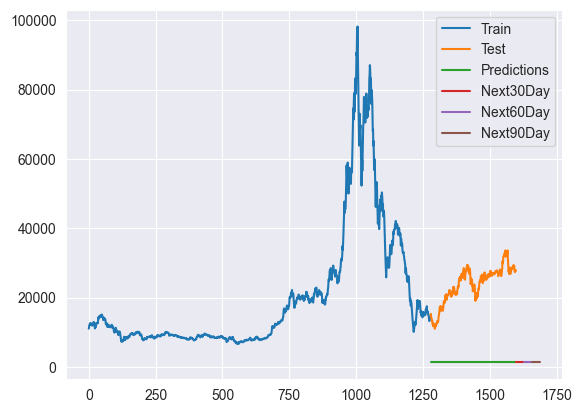

In [8]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [9]:
def plot_model(train, test, y_pred, title):
  mae = mean_absolute_error(test, y_pred)
  train.plot(figsize=(15, 4), legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
  test.plot(legend=True, label="TEST")
  y_pred.plot(legend=True, label="PREDICTION")
  plt.show()

def des_optimizer(train, test, alphas, betas, trend, step):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)
best_alpha, best_beta, best_mae = des_optimizer(x_train, x_test, alphas, betas, trend='add', step=320)
final_model = ExponentialSmoothing(x_train, trend='add').fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
y_pred = final_model.forecast(320)

In [10]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([1278., 1279., 1280., 1281., 1282., 1283., 1284., 1285., 1286.,
       1287., 1288., 1289., 1290., 1291., 1292., 1293., 1294., 1295.,
       1296., 1297., 1298., 1299., 1300., 1301., 1302., 1303., 1304.,
       1305., 1306., 1307., 1308., 1309., 1310., 1311., 1312., 1313.,
       1314., 1315., 1316., 1317., 1318., 1319., 1320., 1321., 1322.,
       1323., 1324., 1325., 1326., 1327., 1328., 1329., 1330., 1331.,
       1332., 1333., 1334., 1335., 1336., 1337., 1338., 1339., 1340.,
       1341., 1342., 1343., 1344., 1345., 1346., 1347., 1348., 1349.,
       1350., 1351., 1352., 1353., 1354., 1355., 1356., 1357., 1358.,
       1359., 1360., 1361., 1362., 1363., 1364., 1365., 1366., 1367.])

In [11]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 22389.0625
RMSE: 22965.14099809753
MAPE: 0.9366651171234228


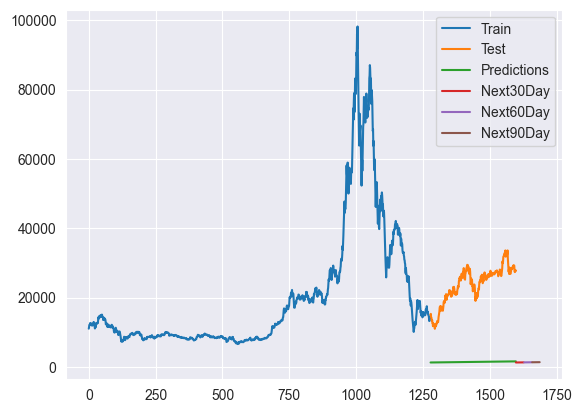

In [12]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [13]:
def tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        if np.isnan(y_pred).any():
            continue  # Skip this combination if y_pred contains NaN values
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='add', seasonal='add', seasonal_periods=12, step=320)
final_model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(320)



In [14]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([ 12227.21077747,  11829.31305922,  11376.30444774,  10663.91787279,
        10123.86527242,   9809.24880087,   9373.22982618,   8776.04913238,
         8631.85152663,   9049.16712337,   8930.79472343,   7646.68299408,
         6852.98118125,   6455.083463  ,   6002.07485152,   5289.68827657,
         4749.63567621,   4435.01920466,   3999.00022996,   3401.81953616,
         3257.62193041,   3674.93752715,   3556.56512721,   2272.45339787,
         1478.75158504,   1080.85386678,    627.8452553 ,    -84.54131965,
         -624.59392001,   -939.21039156,  -1375.22936626,  -1972.41006006,
        -2116.6076658 ,  -1699.29206906,  -1817.664469  ,  -3101.77619835,
        -3895.47801118,  -4293.37572944,  -4746.38434091,  -5458.77091587,
        -5998.82351623,  -6313.43998778,  -6749.45896247,  -7346.63965628,
        -7490.83726202,  -7073.52166528,  -7191.89406522,  -8476.00579457,
        -9269.7076074 ,  -9667.60532565, -10120.61393713, -10833.00051208,
       -11373.05311244, -

In [15]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 82932.11724249843
RMSE: 94770.4732887504
MAPE: 3.2174110963029205


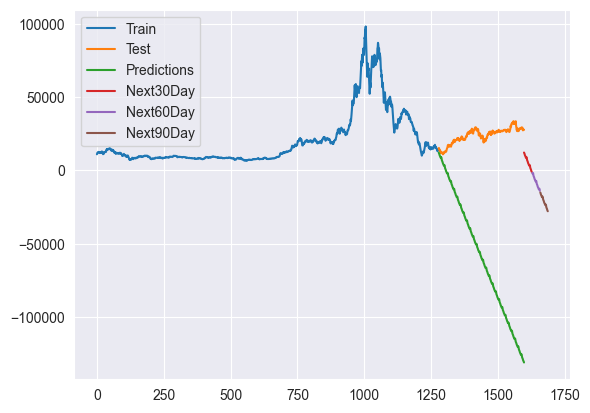

In [16]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [17]:
def tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        try:
            tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
                fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
            y_pred = tes_model.forecast(step)
            if np.isnan(y_pred).any():
                continue  # Skip this combination if y_pred contains NaN values
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        except ValueError as e:
            if "strictly positive" in str(e):
                continue  # Skip this combination if the error is due to non-positive values
            else:
                raise e

    return best_alpha, best_beta, best_gamma, best_mae


alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='mul', seasonal='mul', seasonal_periods=12, step=320)
final_model = ExponentialSmoothing(y_train, trend='mul', seasonal='mul', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(320)


In [18]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([14177.22027527, 14342.35217033, 14313.81004138, 14289.12498984,
       14122.79634629, 14060.81973074, 13965.2450353 , 14050.3638842 ,
       14059.26420357, 14047.05708388, 14152.63842407, 14201.94273362,
       14177.23683792, 14342.36892589, 14313.82676359, 14289.14168321,
       14122.81284535, 14060.83615739, 13965.2613503 , 14050.38029864,
       14059.28062841, 14047.07349446, 14152.654958  , 14201.95932514,
       14177.25340058, 14342.38568147, 14313.84348583, 14289.15837661,
       14122.82934443, 14060.85258407, 13965.27766532, 14050.3967131 ,
       14059.29705327, 14047.08990505, 14152.67149194, 14201.97591669,
       14177.26996326, 14342.40243707, 14313.86020808, 14289.17507002,
       14122.84584353, 14060.86901077, 13965.29398036, 14050.41312758,
       14059.31347814, 14047.10631567, 14152.68802591, 14201.99250825,
       14177.28652596, 14342.41919269, 14313.87693036, 14289.19176346,
       14122.86234265, 14060.88543748, 13965.31029542, 14050.42954208,
      

In [19]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 9952.394657548717
RMSE: 10981.906570830244
MAPE: 0.38986557236943903


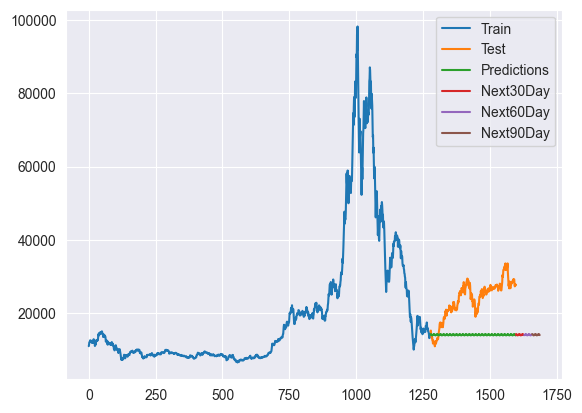

In [20]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [21]:
alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='mul', seasonal='add', seasonal_periods=12, step=320)
final_model = ExponentialSmoothing(y_train, trend='mul', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(320)


In [22]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([14274.60790949, 14361.29928216, 14229.14703694, 14146.52069041,
       13840.87028668, 13814.1978668 , 13970.270763  , 14134.38644269,
       14124.76499827, 14101.73104485, 14228.50850335, 14201.46275336,
       14276.20592148, 14362.89730922, 14230.74507908, 14148.11874761,
       13842.46835895, 13815.79595415, 13971.86886542, 14135.98456019,
       14126.36313084, 14103.32919249, 14230.10666607, 14203.06093116,
       14277.80411435, 14364.49551716, 14232.34330209, 14149.7169857 ,
       13844.06661212, 13817.39422239, 13973.46714874, 14137.58285858,
       14127.96144431, 14104.92752103, 14231.70500968, 14204.65928985,
       14279.40248811, 14366.09390601, 14233.94170601, 14151.3154047 ,
       13845.66504619, 13818.99267154, 13975.06561296, 14139.18133788,
       14129.55993869, 14106.52603049, 14233.30353422, 14206.25782946,
       14281.0010428 , 14367.69247577, 14235.54029085, 14152.91400462,
       13847.26366119, 13820.59130161, 13976.66425812, 14140.77999811,
      

In [23]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 9954.792416495995
RMSE: 10986.017160580306
MAPE: 0.389856504722006


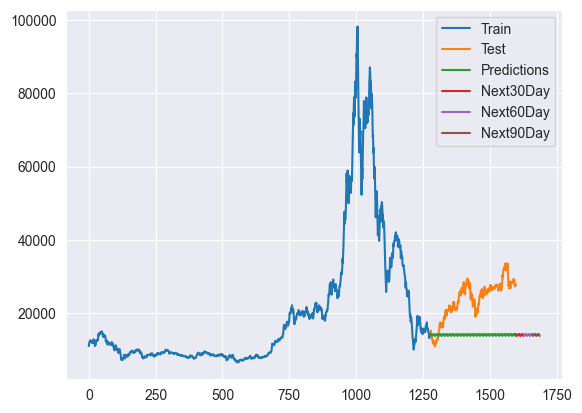

In [24]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [25]:
alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='add', seasonal='mul', seasonal_periods=12, step=320)
final_model = ExponentialSmoothing(y_train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(320)


In [26]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([14176.3498973 , 14340.62432515, 14311.24320494, 14285.71644089,
       14118.58588101, 14055.78288725, 13959.38398857, 14043.60540727,
       14051.65430125, 14038.61771535, 14143.3008017 , 14191.71933865,
       14166.19577437, 14330.3519239 , 14300.99123784, 14275.48214913,
       14108.47071776, 14045.71211752, 13949.38169007, 14033.54216083,
       14041.5846859 , 14028.55684139, 14133.16430051, 14181.54752839,
       14156.04165144, 14320.07952264, 14290.73927074, 14265.24785737,
       14098.35555452, 14035.64134778, 13939.37939157, 14023.47891438,
       14031.51507055, 14018.49596743, 14123.02779931, 14171.37571813,
       14145.88752852, 14309.80712138, 14280.48730365, 14255.01356561,
       14088.24039127, 14025.57057804, 13929.37709307, 14013.41566794,
       14021.4454552 , 14008.43509347, 14112.89129812, 14161.20390787,
       14135.73340559, 14299.53472012, 14270.23533655, 14244.77927386,
       14078.12522802, 14015.4998083 , 13919.37479457, 14003.3524215 ,
      

In [27]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 10085.719304652415
RMSE: 11133.011808661067
MAPE: 0.39493661027439886


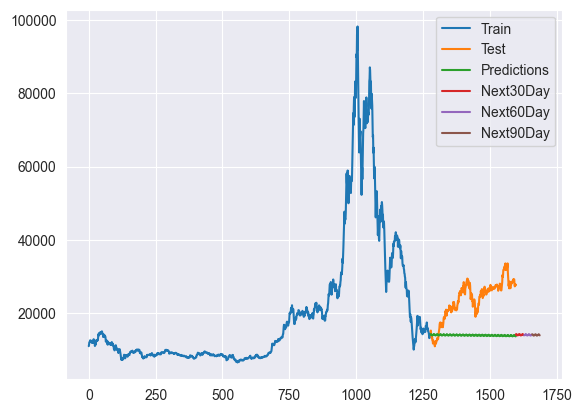

In [28]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

## Observation:
-  Triple Exponential Smoothing with both multiplicative trend and seasonality  acchieve the best MAE, RMSE, MAPE score  -> choose the model